1. 인물모드 직접 해 보기

1) 인물 사진모드

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
import os

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

사진으로 좋아하는 배우님인 서현진 배우님으로 시도해보자.

(358, 613, 3)


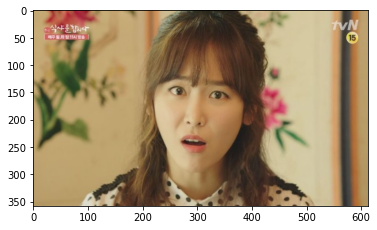

In [3]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/models/Hyunjin.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/AIFFEL/human_segmentation/models/'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/AIFFEL/human_segmentation/models/
model loaded successfully!


(358, 613, 3)


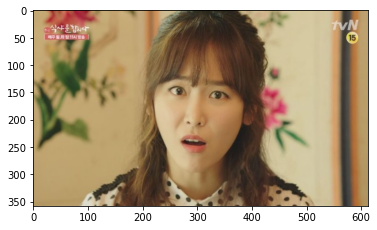

(0.0, 256.0)

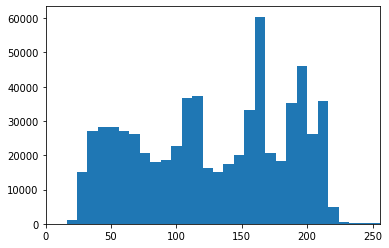

In [5]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/models/Hyunjin.jpg'     
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()
fig, ax = plt.subplots(1, 1)
ax.hist(img_orig.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

In [6]:
# 준비한 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(358, 613, 3) (299, 513, 3) 15


In [7]:
# DeepLab의 PASCAL VOC 라벨

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

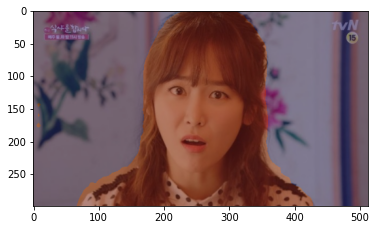

In [8]:
# 세그멘테이션

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)  # 색 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

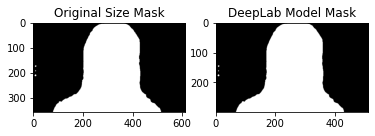

In [9]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

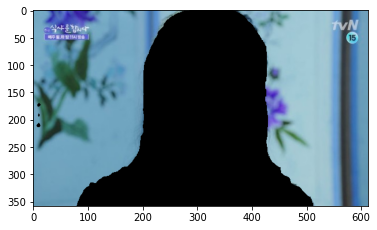

In [10]:
# 세그멘테이션 마스크를 이용하여 배경만 추출

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)       #이미지 반전! 배경은 255, 사람이 0
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)     #배경만 있는 연산 get

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

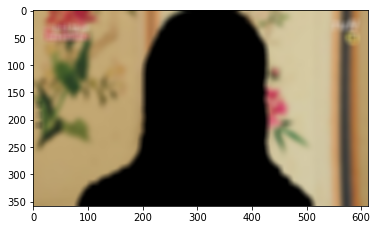

In [11]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

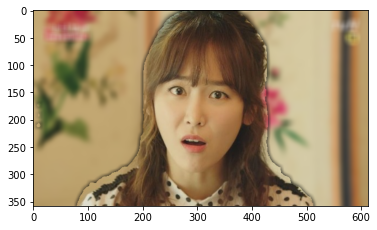

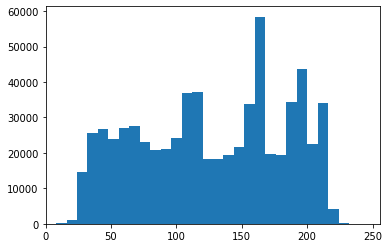

In [12]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('me1_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

첫번째 사진의 문제점
뒤에 배경 부분과 옷과 색이 비슷하여 조금 같이 인식되었으나 크게 문제는 없는 부분으로 보인다.

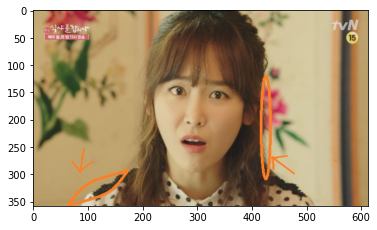

In [17]:
a1 = plt.imread(os.getenv('HOME')+'/aiffel/human_segmentation/models/Hyunjin_problem.jpg')
plt.figure(figsize=(6,8))
plt.imshow(a1)

2) 2번째 사진

In [18]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/models/Hyunjin2.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(960, 960, 3)


In [19]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(960, 960, 3) (513, 513, 3) 15


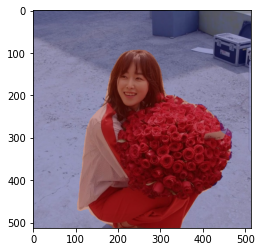

In [20]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

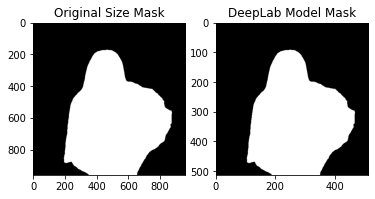

In [21]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

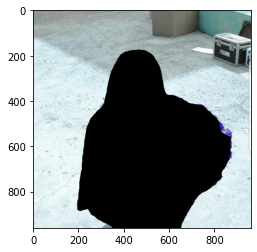

In [22]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

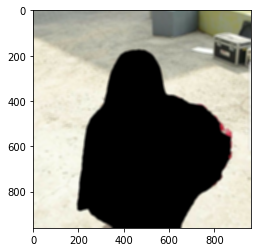

In [23]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

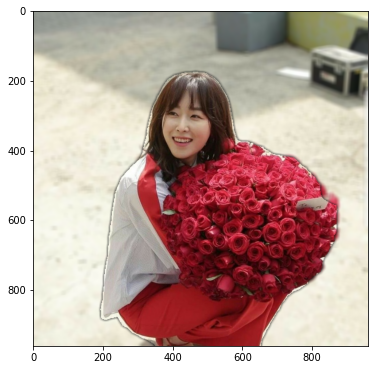

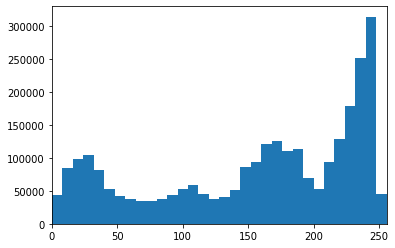

In [24]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('me2_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

2번째 사진 문제점?
현진 배우님은 인식이 잘 되었고, 거대한 꽃다발을 앉고 계신데 꽃다발도 비교적 정확히 인식하고 있다.
딱히 뭔 문제는 없는 것 같다. 이대로 끝낼 수는 없으니 현진 배우님의 다른 사진들을 더 가져와보자.

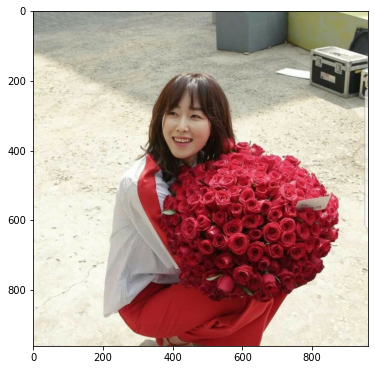

In [25]:
b1 = plt.imread(os.getenv('HOME')+'/aiffel/human_segmentation/models/Hyunjin2.jpg')
plt.figure(figsize=(6,8))
plt.imshow(b1)

3) 3번째 사진

In [26]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/models/Hyunjin3.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1200, 800, 3)


In [27]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1200, 800, 3) (513, 342, 3) 15


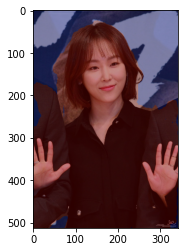

In [28]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

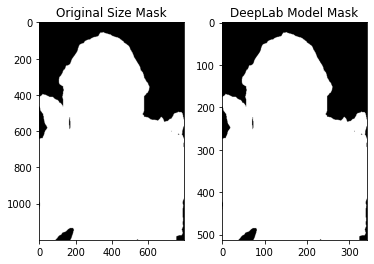

In [29]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

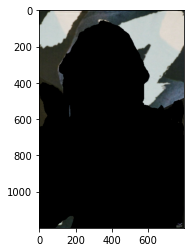

In [30]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

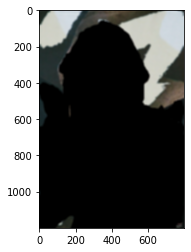

In [31]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

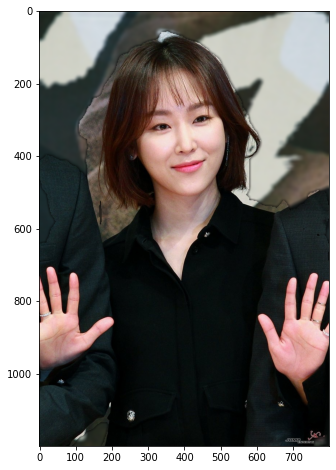

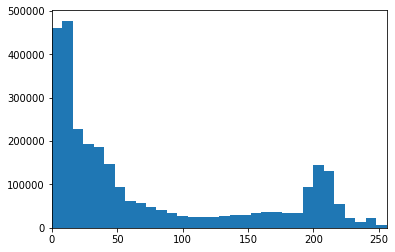

In [32]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('me3_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

세번째 사진 문제점) 
현진 배우님의 얼굴은 모두 인식하였으나, 검은 배경과 머리카락, 옷 색을 헷갈려했는지 얼굴이 좀 더 크게 잡혀있다.
손가락과 배경 사이사이 손가락들을 모두 인식하지 못하는 모습을 보인다.

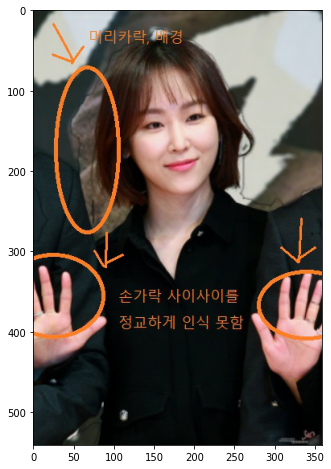

In [33]:
c1 = plt.imread(os.getenv('HOME')+'/aiffel/human_segmentation/models/Hyunjin3_problem.jpg')
plt.figure(figsize=(6,8))
plt.imshow(c1)

4) 4번째 사진

In [34]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/models/Hyunjin4.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(700, 920, 3)


In [35]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(700, 920, 3) (390, 513, 3) 15


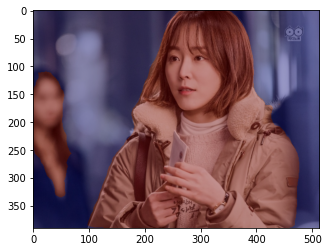

In [36]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

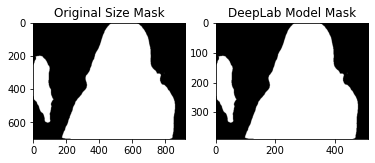

In [37]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

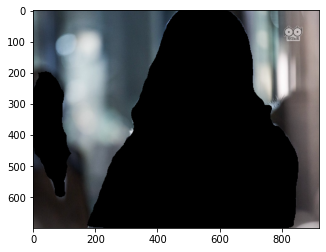

In [38]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

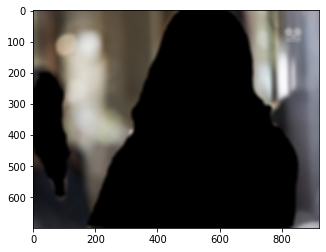

In [39]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

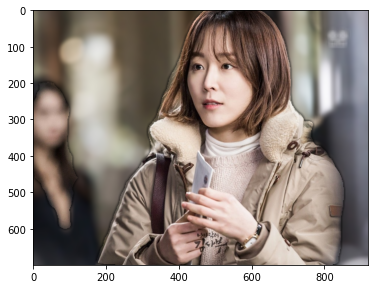

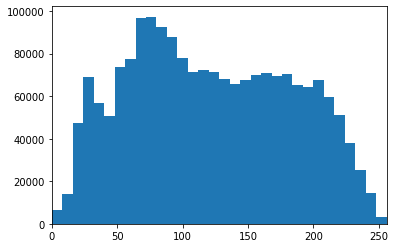

In [40]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('me3_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

네번째 사진 문제점) 현진 배우님의 얼굴, 옷 사진 등은 정확히 인식하였으나, 뒤에 있는 사람도 같이 인식하는 모습을 보인다. 

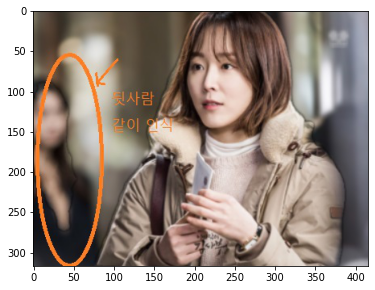

In [41]:
d1 = plt.imread(os.getenv('HOME')+'/aiffel/human_segmentation/models/Hyunjin4_problem.jpg')
plt.figure(figsize=(6,8))
plt.imshow(d1)

이번에는 미국 톱스타 Katy Perry 님으로 해보자.

In [42]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/models/KatyPerryNetWorthNew.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(853, 1280, 3)


In [43]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(853, 1280, 3) (341, 513, 3) 15


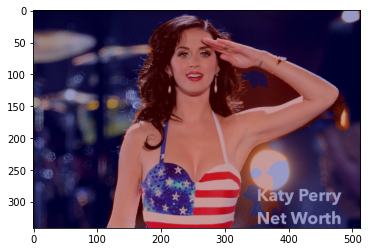

In [44]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

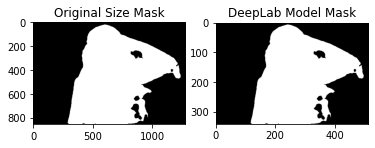

In [45]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

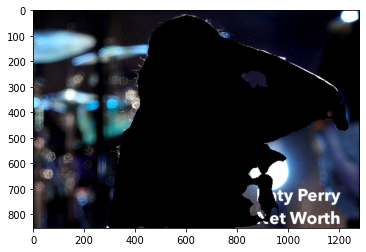

In [46]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

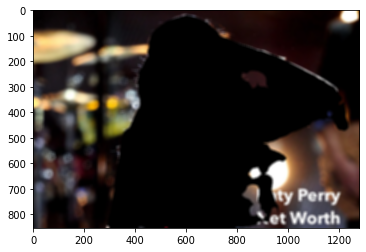

In [47]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

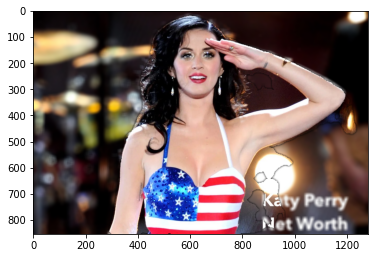

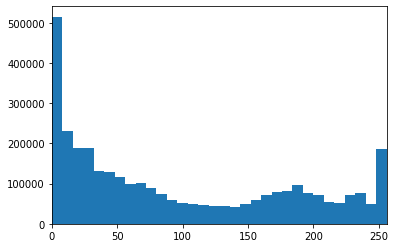

In [48]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('cat1_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

사진 문제점) Katy Perry 님은 경례 포즈를 취하고 있는데 왼팔이 꺾여 있는 부분을 인식하지 못하는 모습을 보여주고 있다. 또 왼팔 아래쪽에 조명이 있는데 이를 같이 인식한 것으로 보인다.

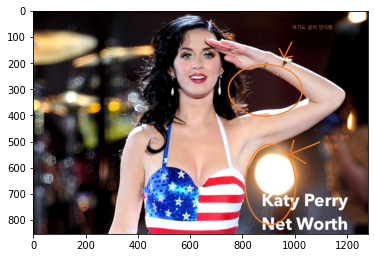

In [63]:
e1 = plt.imread(os.getenv('HOME')+'/aiffel/human_segmentation/models/KatyPerryNetWorthNew_problem.jpg')
plt.figure(figsize=(6,8))
plt.imshow(e1)

# 인물 모드 사진의 문제점 해결 방법

인물 사진을 인식시켜본 결과, 대체로 잘 인식되나 몇 가지 오류가 발견되었는데,

사람과 배경과의 경계가 뚜렷하게 구분되지 않는다는 것, 신체와 배경이 겹치게 되는 경우(특히 서현진 배우님 손가락, 케이티 페리님 팔)가 있다. 또 여러 사람이 있는 경우 흐릿하지만 같이 인식한다는 문제가 있다.

사용한 모델은 DeepLab V3+인데, DeepLab은 Semantic segmentation의 정확성을 높이기 위한 방법으로 atrous convolution을 사용한다. 특히 V3+는 separable convolution과 atrous convolution을 결합한 atrous separable convolution을 활용하여 모델을 설계한다.
정확도 높은 모델이지만 그래도 발생하는 한계를 보완하기 위해, 2D인 사진에 픽셀의 depth 정보를 넣어주어 Semantic segmentation의 정확성을 높일 수 있을 것으로 보인다. 3D 카메라나 센서가 없다는 가정하에, 단일 이미지마다의 depth를 예측해주는 모델을 사용하여 depth를 측정하고, depth가 반영된 이미지를 추가하여 3d 이미지와 같은 output을 얻을 수 있기 때문에 경계의 부정확성이나 오차를 줄일 수 있을 것으로 보인다.

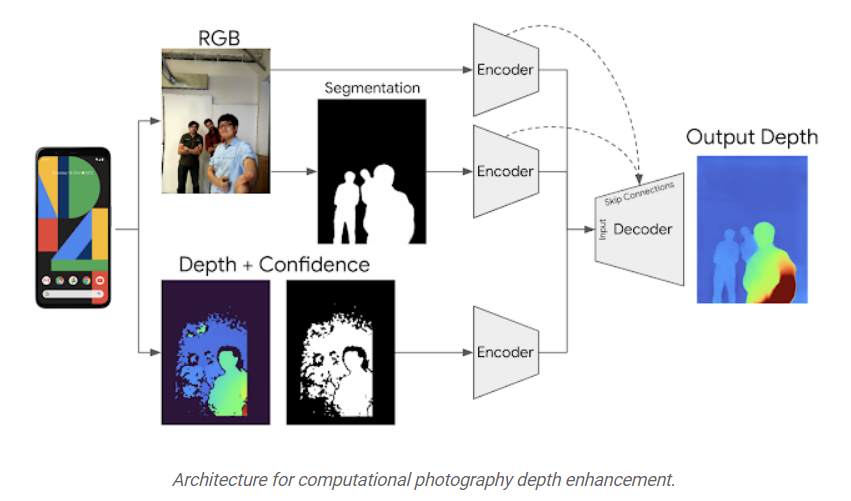

(출처 https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html)

# 회고

DeepLabV3+ 모델을 이용해 아웃포커싱 기법이 적용된 것 같은 사진을 만들어, 결과적으로 모든 사진의 인물들이 잘 인식되었다.
어쩌다 보니 서현진 배우님 뒷사람도 같이 인식되어 신기했다. 흐릿한 형태지만 이걸 인식할 수 있다는 것이 신기했다. 포토샵으로 직접 배경제거를 할 때도 있고 급할 때에는 배경제거 사이트에 사진을 넣어 제거하는 경우도 있는데, 배경제거 사이트가 이렇게 만들어질 수 있다는 것이 신기했다. 여기서 발전시키면 나도 무료 포토샵 사이트 하나 만들어두어도 될 듯 하다.